### Requisitos del proyecto
Debe contener lo siguiente:

1. Explicación del problema a resolver (cuáles son los inputs y porqué, cual es la salida y porqué, cómo se obtuvieron y de dónde)
2. Análisis de los datos (histogramas, visualización de una muestra tanto la entrada como la salida, normalización encaso de ser necesaria)
3. Separación de los datos (seleccionar un porcentaje para cada conjunto)
4. Definición, Entrenamiento y Evaluación de la red neuronal
5. Inferencia (usando los datos de prueba)
6. Comentario: explicar porqué se obtuvieron esos resultados

# LaTeX Parser

### I. Explicación del problema
_____
_____

El problema a resolver es la traducción de imágenes con ecuaciones matemáticas a una secuencia de símbolos que $\LaTeX$ utiliza para generar ecuaciones matemáticas:

![traduccion](images/diag2.png)

Para ello se empleará el modelo *Sequence-to-Sequence* (S2S), este modelo es un caso especial de una familia general de modelos llamados: *encoder-decoder models*, que son una composición de dos modelos: *encoder* y *decoder*, que suelen ser entrenados en conjunto.

![encoder-decoder](images/encoder-decoder.png)

El modelo encoder es usualmente una red neuronal convolucional (CNN) que transforma imágenes en un grupo de mapas de características, o una representación $(\Phi)$, que es generalmente un vector. El decoder por otro lado, es usualmente una red enuronal recurrente (RNN) que tiene como meta tomar la representación ($\Phi$) de la entrada y producir la salida deseada. A partir de lo anterior, se puede definir a los modelos S2S como modelos encoder-decoder, en los que el encoder y el decoder son modelos de secuencia y las entradas y salidas son secuencias, posiblemente de diferentes longitudes.

#### I.I Entrada y salida (Contexto a la solución del problema)   
___



Si se define a una imagen de una ecuación matemática generada con LaTeX como: $(x,y)$, en donde $x \in \mathbb{R}^{H \times W}$ es una imagen en escala de grises de altura $H$ y ancho $W$, $y = [y_1,...y_T]$ es una secuancia de $T$ símbolos que definen la fórmula matemática de la imagen. La meta es obtener la salida $y$ a partir de la entrada $x$, es decir, encontrar una función $f: f(x) \longrightarrow y$.  

Dado un conjunto de imágenes $(x_i,y_i)\,i \in \{1,...,N\}$, se puede usar entrenamiento supervisado para construir una función de predicción de secuencia $f'$ que aproxime a $f$, $f': f'(x) \longrightarrow y'$, para predecir una secuencia de $LaTeX$ $y'$ que reconstruya la imagen $x$. La evaluación se puede realizar mediante la comparación de $y'$ y $y$, y entre la imagen $x'$ creada a partir de $y'$, con la original $x$.

#### I.II Obtención de los datos
___

Los datos se obtuvieron de la página [LSTMVis](http://lstm.seas.harvard.edu/), una herramienta de análisis visual para redes neuronales.

Para descargar el conjunto de datos:  
- Estar en la carpeta de images: `cd src/data/sets/raw/images`
- Descargar el dataset: `sudo tar -zxvf formula_images_processed.tar.gz`
- Comando sugerido para copiar los datos .png una vez descomprimidos a la carpeta de images:  
`find /src/data/sets/raw/images/formula_images_processed/ -name "*.png" -exec cp -uf "{}" /src/data/sets/raw/images/ \;`


**Referencias:**  
[1] Delip Rao & Brian McMahan, *Natural Language Processing with PyTorch*, (2019) Chapter 8.  
[2] [Translating Math Formula Images to LaTeX Sequences Using Deep Neural Networks with Sequence-level Training](https://arxiv.org/pdf/1908.11415.pdf)  
[3] [Image-to-Markup Generation with Coarse-to-Fine Attention](http://lstm.seas.harvard.edu/latex/)

### II. & III. Análisis de los datos y Separación de datos
___
___

Importación de librerías

In [1]:
# Dependencies 
import random
import statistics
from functools import partial
import time
import tqdm

In [2]:
# TORCH
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
# PROJECT
from architecture import *

from data import DataBuilder

from utilities.dataloaders import *
from utilities.training import *
from utilities.latex_gen import *

from utilities.tensor import *
from utilities.persistance import *
from utilities.logger import *

In [4]:
# Hardware
device = "cuda:0" if torch.cuda.is_available() else "cpu"
num_workers = 1 #2

División de los datos en conjuntos train, validation y test / hiperparámetros de entrenamiento:

In [5]:
# ********************************************************************
# **********************  Hyper parameters  **************************
# ********************************************************************
    
# data
num_data_train = 100000  # max
num_data_val = 20000  # max
num_data_test = 2000  # max
batch_size = 10 #50
    
# training
epochs = 5  # default 10
learning_rate = 3e-4 #default 3e-4
drop_out = 0.2 # default 0.2
clip = 2 #default 2

Obtención de los datos:  
(Para ver los códigos de la obtención de datos: `/src/data/`)

In [6]:
# ********************************************************************
# **********************  Get data  **********************************
# ********************************************************************
data_builder = DataBuilder()

vocabulary = data_builder.get_vocabulary()

force = True
train_dataset = data_builder.get_dataset_for('train', max_count=num_data_train, force=force)
valid_dataset = data_builder.get_dataset_for('validate', max_count=num_data_val, force=force)
test_dataset = data_builder.get_dataset_for('test', max_count=num_data_test, force=force)

num_data_train = len(train_dataset)
num_data_val = len(valid_dataset)
num_data_test = len(test_dataset)

print("+"*8+" Información sobre el número de datos: "+"+"*8)
print("Número de datos train:", num_data_train)
print("Número de datos validation:", num_data_val)
print("Número de datos test:", num_data_test)


++++++++ Información sobre el número de datos: ++++++++
Número de datos train: 75275
Número de datos validation: 8370
Número de datos test: 2000


Visualización de dos datos de entrada:

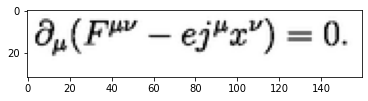

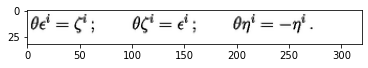

In [7]:
show_tensor_as_image(train_dataset[6][0])
show_tensor_as_image(train_dataset[50][0])

Visualización de dos datos de salida: (correspondiente a los de entrada)

In [8]:
print(train_dataset[6][1])
print(train_dataset[50][1])

\partial _ { \mu } ( F ^ { \mu \nu } - e j ^ { \mu } x ^ { \nu } ) = 0 .
\theta \epsilon ^ { i } = \zeta ^ { i } \, ; \qquad \theta \zeta ^ { i } = \epsilon ^ { i } \, ; \qquad \theta \eta ^ { i } = - \eta ^ { i } \, .


### IV. Definición, Entrenamiento y Evaluación  
___
___

#### IV.I Arquitectura de la red

In [9]:
# ********************************************************************
# **********************  Architecture  ******************************
# ********************************************************************

model = Model(
out_size=len(vocabulary),
enc_out_dim=512,
emb_size=80,
dec_rnn_h=512,
dropout=drop_out
)

Para ver el código del modelo completo: `/src/architecture/model.py` 

#### IV.II Entrenamiento

In [10]:
# ********************************************************************
# **********************  Training  **********************************
# ********************************************************************

# Hyper parameters for training 
init_epoch = 1

# For epsilon calculation
decay_k = 1 #default
sample_method = "inv_sigmoid" #default ["exp", "inv_sigmoid", "teacher_forcing")

# Dataloaders
train_loader = DataLoader (
    train_dataset,
    batch_size=batch_size,
    #TODO how collate works?
    # https://discuss.pytorch.org/t/how-to-create-a-dataloader-with-variable-size-input/8278
    collate_fn=partial(collate_fn, vocabulary.token_id_dic),
    pin_memory=False, # It must be False (no GPU): https://discuss.pytorch.org/t/when-to-set-pin-memory-to-true/19723
    #shuffle=True,
    num_workers=num_workers
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    collate_fn=partial(collate_fn, vocabulary.token_id_dic)
    )


In [11]:
# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
lr_scheduler = ReduceLROnPlateau(
    optimizer,
    "min",
    factor=0.5, # float default - Learning rate decay rate
    patience=3, # int default - Learning rate decay patience
    verbose=True,
    min_lr=3e-5) # default 3e-5

In [12]:
# Variables to save results
training_losses = []
valid_losses = []
total_step = 0
best_valid_loss = 1e18

In [ ]:
# For profiling
logger = TrainingLogger(print_freq=10)

for epoch in range(epochs):
    step_losses = []
    step = 1

    # Training
    model.train()
    loader_len = len(train_loader)
    for imgs_batch, tgt4training_batch, tgt4loss_batch in train_loader:
        optimizer.zero_grad()

        # Epsilon
        #epsilon = cal_epsilon(decay_k, total_step, sample_method)

        # Prediction
        logits = model(imgs_batch, tgt4training_batch, 1.)

        # Compute Loss
        step_loss = cal_loss(logits, tgt4loss_batch)
            
        # Add loss
        step_losses.append(step_loss.item())

        # Print results
        logger.log_train_step(epoch+1, epochs, step, loader_len, statistics.mean(step_losses))

        # Updates
        step_loss.backward()
        clip_grad_norm_(model.parameters(),clip)
        optimizer.step()

        step += 1
        total_step += 1
        
    training_losses.append(statistics.mean(step_losses))

+++++++++++++++ Training initialized +++++++++++++++
[Train] Epoch 1/5 Step 10/7528 Loss 5.413578
[Train] Epoch 1/5 Step 20/7528 Loss 4.893776
[Train] Epoch 1/5 Step 30/7528 Loss 4.630878
[Train] Epoch 1/5 Step 40/7528 Loss 4.477638
[Train] Epoch 1/5 Step 50/7528 Loss 4.405375
[Train] Epoch 1/5 Step 60/7528 Loss 4.358254
[Train] Epoch 1/5 Step 70/7528 Loss 4.294891
[Train] Epoch 1/5 Step 80/7528 Loss 4.264323
[Train] Epoch 1/5 Step 90/7528 Loss 4.227040
[Train] Epoch 1/5 Step 100/7528 Loss 4.207898
[Train] Epoch 1/5 Step 110/7528 Loss 4.186956
[Train] Epoch 1/5 Step 120/7528 Loss 4.165333
[Train] Epoch 1/5 Step 130/7528 Loss 4.128827
[Train] Epoch 1/5 Step 140/7528 Loss 4.100134
[Train] Epoch 1/5 Step 150/7528 Loss 4.066745
[Train] Epoch 1/5 Step 160/7528 Loss 4.042028
[Train] Epoch 1/5 Step 170/7528 Loss 3.995395
[Train] Epoch 1/5 Step 180/7528 Loss 3.973333
[Train] Epoch 1/5 Step 190/7528 Loss 3.940873
[Train] Epoch 1/5 Step 200/7528 Loss 3.904271
[Train] Epoch 1/5 Step 210/7528 Loss

[Train] Epoch 1/5 Step 1770/7528 Loss 2.993692
[Train] Epoch 1/5 Step 1780/7528 Loss 2.992780
[Train] Epoch 1/5 Step 1790/7528 Loss 2.991254
[Train] Epoch 1/5 Step 1800/7528 Loss 2.988991
[Train] Epoch 1/5 Step 1810/7528 Loss 2.987697
[Train] Epoch 1/5 Step 1820/7528 Loss 2.986625
[Train] Epoch 1/5 Step 1830/7528 Loss 2.984322
[Train] Epoch 1/5 Step 1840/7528 Loss 2.982423
[Train] Epoch 1/5 Step 1850/7528 Loss 2.980699
[Train] Epoch 1/5 Step 1860/7528 Loss 2.978636
[Train] Epoch 1/5 Step 1870/7528 Loss 2.976855
[Train] Epoch 1/5 Step 1880/7528 Loss 2.974466
[Train] Epoch 1/5 Step 1890/7528 Loss 2.972974
[Train] Epoch 1/5 Step 1900/7528 Loss 2.971567
[Train] Epoch 1/5 Step 1910/7528 Loss 2.970009
[Train] Epoch 1/5 Step 1920/7528 Loss 2.969070
[Train] Epoch 1/5 Step 1930/7528 Loss 2.967395
[Train] Epoch 1/5 Step 1940/7528 Loss 2.965414
[Train] Epoch 1/5 Step 1950/7528 Loss 2.964785
[Train] Epoch 1/5 Step 1960/7528 Loss 2.962955
[Train] Epoch 1/5 Step 1970/7528 Loss 2.960827
[Train] Epoch

#### IV.III Validation

In [ ]:
    # Validation
    model.eval()
    step_losses = []
    with torch.no_grad(): # This disable any gradient calculation (better performance)
        for imgs_batch, tgt4training, tgt4loss_batch in valid_loader:

            # Epsilon
            #epsilon = cal_epsilon(decay_k, total_step, sample_method)

            # Prediction
            pred = model(imgs_batch, tgt4training, 1.)

            # Compute loss
            step_loss = cal_loss(pred, tgt4loss_batch)
            step_losses.append(step_loss.item()) 

            # Print results
            logger.log_val_step(epoch+1, epochs, statistics.mean(step_losses))
   

In [ ]:
    # Best validation loss
    valid_loss = statistics.mean(step_losses)
    if valid_loss < best_valid_loss: #best valid loss
        best_valid_loss = valid_loss
        save_model("best_ckpt", model)

    # Scheduler
    lr_scheduler.step(valid_loss)
    valid_losses.append(valid_loss)

    # Save model checkpoint ckpt-e{epoch}
    save_model(f"ckpt-e{epoch+1}-vl{valid_loss:.4f}", model)

    # Print results
    logger.log_epoch(epoch+1, epochs, statistics.mean(training_losses), statistics.mean(valid_losses))

del logger

# ********************************************************************
# **********************  Testing  ***********************************
# ********************************************************************

    latex_generator = LatexGenerator(model, vocabulary)

    # Loader
    test_loader = DataLoader(
        dataset=test_dataset,
        collate_fn=partial(collate_fn_batch_size_one, vocabulary.token_id_dic)
    )

    # Save testing data
    targets = []
    predictions = []
    for img, formula in test_loader:
        try:
            prediction = latex_generator(img)[0]
            targets.append(formula)
            predictions.append(prediction)
        except RuntimeError:
            break
    
    SAVE_TEST_DATA(F"RES_{EPOCHS}_{BATCH_SIZE}_{INT(NUM_DATA_TRAIN/1000)}K_{INT(NUM_DATA_VAL/1000)}K_{INT(NUM_DATA_TEST/1000)}K", TARGETS, PREDICTIONS)

In [ ]:
print(test_dataset._pairs[3][1])